# Definición del problema

La busqueda de una nueva casa o departamento, ya sea para la compra o el arriendo de esta, es un problema clásico que se ven enfrentado la gran mayoría de las personas en alguna étapada de su vida. Los obstaculos dado los recursos límitados de las persoans van desde los precios límites dispuestos a desembolsar, la ubicación de la vivienda, el número mínimo o máximo de habitaciones, baños, estacionamientos, entre otros, la cercanía a estaciones de metro, supermercados, farmacias, entre otros. Las razones para escoger una vivienda es un problema múltifactorial que se ve influenciado por los gustos y preferencias de la persona, y que al final de la busqueda se traduce en comprar/arrendar o no una vivienda.

El caso especifico del presente trabajo nace de la problematica del investigador y su pareja que, a la fecha del desarrollo del trabajo estan en busqueda de arrendar el departamento ideal para ellos, por lo que, se desea buscar un método de clasificación el cuál deberá indicar si se trata o no (binario) de un departamento acorde a las preferencias de la pareja, dado los ejemplos que estos les enseñaran al método.

# Descripción del conjunto de datos

El conjunto de datos fue obtenido desde el sitio web Portal Inmobiliario a través del método *web-scraping* programado por el investigador ([github del scraping](https://github.com/smenaaliaga/rent-apartment-system/blob/main/scraping/scp_portalinmobiliario.py)), del sitio se extrajo la totalidad de la oferta de arriendos de departamentos al día viernes 29 de abril 2022, de las comunas La Florida, Macul, Peñalolen, Ñuñoa, La Reina, Providencia y Las Condes, extrayendo un total de 2559 departamentos. 

La extracción de los datos consideró un preprocesamiento de los datos, eliminando texto y cáracteres especial de algunas variables numericas tales como el precio, los m2 de la superficie, entre otros. También se optó por tratar la extracción de la descripciones de los departamentos, aplicando *lowercase* al texto, normalización a ASCII y eliminación de cáracteres especiales. Por otro lado, no todos los departamentos tenían el valor de su gasto común en la sección habilitada por el sitio, y muchas veces los oferentes del departamento optaban por ingresar el valor del gasto común en la descripción, por lo que, se automatizó su obtención desde la descripción cuando esta no se encontraba en la sección de gastos comunes.

Sin embargo, no todo el preprocesamiento de los datos se pudo automatizar desde el *script* ya que, luego de la extracción se observaron algunos datos atípicos, como por ejemplo, departamentos con 28 baños u otro con 10 estacionamientos, estos casos fueron corregidos manualmente contrastandolo con la información dada por la descripción. Además, se observaron unos pocos casos de departamentos con precios de arriendos desorbitantes, sin embargo, al realizar el contraste se concluyó que se trataba de departamentos en venta mal clasificados como en arriendo, estos casos fueron eliminados. También se eliminaron algunas duplicidades a través de una herramienta llamada KNIME, al final se obtuvieron un total de 2401 departamentos.

Las variables obtenidas son :

- titulo : Titulo descriptivo del departamento
- comuna : Comuna donde esta ubicado el departamento
- estacion_cercana : Estación de metro cercana, si es que posee (menos de 2 km)
- distancia_estacion : Distancia (en metros) de la estación más cercana, si es que posee
- dormitorios : Cantidad de dormitorios
- baños : Cantidad de baños
- estacionamientos : Cantidad de estacionamientos
- bodegas : Cantidad de bodegas
- superficie_total : Superficie total del departamento en metros cuadrados (m2)
- superficie_util : Superficie util del departamento en metros cuadrados (m2)
- currency_symbol : Tipo de unidad monetaria cual se paga el precio del departamento (UF o CLP)
- precio : Precio mensual del arriendo del departamento en CLP
- gastos_comunes : Valor del gasto común en CLP
- search_gc : Indicador de donde a obtenido el gasto común, 0 si lo obtuvo directamente o 1 si fue desde la descripción
- descripcion : Descripción del departamento
- ubicacion : Ubicación del departamento
- url : URL original de donde se obtuvo la data del departamento

Es importante señalar que las variables "titulo", "currency_symbol", "search_gc", "ubicación" y "url" son únicas por departamento o no entregan información adicional para la clasificación, por lo que no fueron consideradas dentro de la investigación. Además, se excluye de la investigación la variable "descripcion" aún sabiendo que en ella hay información relevante para la clasificación, esta variable será considerada para futuros trabajos.

Finalmente, un trabajo no menor fue la clasificación realizado por el investigador y su pareja, en el cuál se etiquetó cada departamento con un 1 si el departamento era de sus preferencias y 0 en caso contrario, cabe destacar que todos los departamentos con un precio más gasto común mayor a 550.000 CLP fueron automaticamente clasificados como 0, añadiendo una nueva columna llamada **preferencia** al *dataset*.

# Carga y preprocesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carga
df = pd.read_csv('data/departamentos.csv')
# Conversión del tipo de dato
df['precio'] = df['precio'].astype(float)
df['gastos_comunes'] = df['gastos_comunes'].astype(float)
df['superficie_total'] = df['superficie_total'].replace(to_replace=",", value='.', regex=True)
df['superficie_total'] = df['superficie_total'].astype(float)
df['superficie_util'] = df['superficie_util'].replace(to_replace=",", value='.', regex=True)
df['superficie_util'] = df['superficie_util'].astype(float)
# Filtro de variables no consideradas
df = df[df.columns[~df.columns.isin(['titulo','currency_symbol','search_gc', 'descripcion','ubicacion','url'])]]
# Precio total
df['total'] = df['precio'] + df['gastos_comunes']
# Filtrar departamentos menores o iguales a 600.000 CLP
df = df.loc[(df['total'] <= 600000)]
# Forma del dataset
df.shape

(267, 13)

## Revisión de NaNs y su tratamiento

In [3]:
# Revisión de NaN
pd.isna(df).sum()

preferencia             0
comuna                  0
estacion_cercana       59
distancia_estacion     59
dormitorios             1
baños                   1
estacionamientos       95
bodegas               171
superficie_total        4
superficie_util         5
precio                  0
gastos_comunes          0
total                   0
dtype: int64

#### Tratamiento de variables "estación_cercana" y "distancia_estacion"

Si el valor en "estación_cercana" y "distancia_estacion" no esta presente, es por que el departamento no presenta estaciones cercanas

In [4]:
df['estacion_cercana'] = df['estacion_cercana'].fillna('Sin estación cercana')
# Si la estación esta lejana, se añade 3000 mts como referencia
# Recordar que una estación cercama se considera como menor a 2000 mts 
df['distancia_estacion'] = df['distancia_estacion'].fillna(3000)

#### Tratamiento de variables "estacionamientos" y "bodegas"

Se considera que si el valor de la "estacionamientos" y "bodegas" no estan presentes, es por que el departamento no las posee, por lo tanto se añade 0

In [5]:
df['estacionamientos'] = df['estacionamientos'].fillna(0)
df['bodegas'] = df['bodegas'].fillna(0)

Las otras variables faltantes representan un subconjuntos marginal respecto al total, por lo que se decide remover del dataset

In [6]:
df = df.dropna()
df.shape

(260, 13)

# Análisis Exploratorio de Datos (AED)

In [7]:
# Observación de los primeros datos del conjunto
df.head()

,preferencia,comuna,estacion_cercana,distancia_estacion,dormitorios,baños,estacionamientos,bodegas,superficie_total,superficie_util,precio,gastos_comunes,total
2,0,La Reina,Fernando Castillo Velasco,1433.0,2.0,1.0,0.0,0.0,45.0,45.0,370000.0,5000.0,375000.0
9,0,La Reina,Simón Bolívar,485.0,1.0,1.0,1.0,0.0,24.0,18.0,380000.0,0.0,380000.0
25,0,La Florida,Rojas Magallanes,462.0,2.0,2.0,1.0,1.0,65.0,60.0,450000.0,90000.0,540000.0
27,0,La Florida,Vicente Valdés,70.0,2.0,1.0,1.0,0.0,58.0,56.0,450000.0,55000.0,505000.0
28,0,La Florida,Los Quillayes,835.0,3.0,1.0,0.0,0.0,55.0,55.0,380000.0,25000.0,405000.0


In [8]:
# Tipos de datos del conjunto
df.dtypes

preferencia             int64
comuna                 object
estacion_cercana       object
distancia_estacion    float64
dormitorios           float64
baños                 float64
estacionamientos      float64
bodegas               float64
superficie_total      float64
superficie_util       float64
precio                float64
gastos_comunes        float64
total                 float64
dtype: object


### Variable Y de respuesta :

- preferencia

### Variables X predictoras :

Variables categoricas,

- comuna
- estacion_cercana

Variables cuatitativas discretas,

- dormitorios
- baños
- estacionamientos
- bodegas

Variables cuantitativas continuas,

- distancia_estacion
- superficie_total
- superficie_util
- precio
- gastos_comunes
- total

## Resumen de la variable Y de respuesta: preferencia

In [9]:
df.groupby(['preferencia'])['preferencia'].count().sort_values(ascending=False)

preferencia
0    220
1     40
Name: preferencia, dtype: int64

In [10]:
40/220

0.18181818181818182

## Resumen variables predictora cuantitativas

In [11]:
# Resumén estadístico de variables númericas
df[df.columns[~df.columns.isin(['preferencia'])]].describe()

,distancia_estacion,dormitorios,baños,estacionamientos,bodegas,superficie_total,superficie_util,precio,gastos_comunes,total
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,1101.050000,1.438462,1.246154,0.657692,0.369231,46.207885,43.571038,454802.873077,60719.938462,515522.811538
std,1082.226898,0.596047,0.431600,0.483450,0.483527,12.426624,12.712218,62295.462586,25037.760856,68945.620914
min,46.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,190000.000000,0.000000,245000.000000
25%,334.250000,1.000000,1.000000,0.000000,0.000000,37.007500,35.000000,420000.000000,50000.000000,480016.500000
50%,559.500000,1.000000,1.000000,1.000000,0.000000,45.000000,42.000000,460000.000000,60000.000000,530000.000000
75%,1726.250000,2.000000,1.000000,1.000000,1.000000,55.000000,51.632500,500000.000000,75750.000000,570000.000000
max,3000.000000,3.000000,2.000000,2.000000,1.000000,80.000000,80.000000,600000.000000,120000.000000,600000.000000


Text(0.5, 0.98, 'Diagramas de barras de dormitorios, baños y estacionamientos')

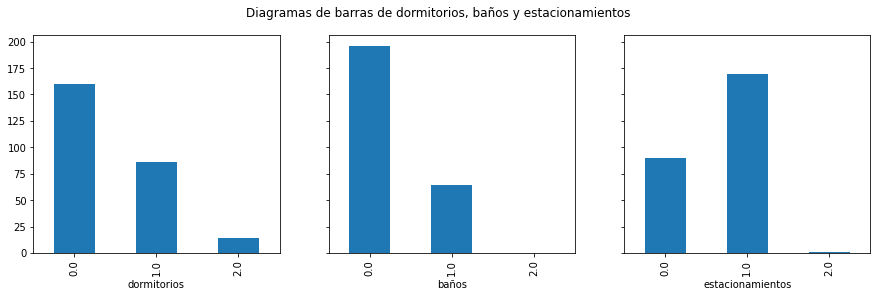

In [12]:
figure, axs = plt.subplots(1,3, figsize=(15,4), sharey=True, sharex=True)
df.groupby(['dormitorios'])['dormitorios'].count().plot(kind='bar', ax=axs[0])
df.groupby(['baños'])['baños'].count().plot(kind='bar', ax=axs[1])
df.groupby(['estacionamientos'])['estacionamientos'].count().plot(kind='bar', ax=axs[2])
plt.suptitle("Diagramas de barras de dormitorios, baños y estacionamientos")

Text(0.5, 1.0, 'Histograma de distancias a estaciones más cercanas')

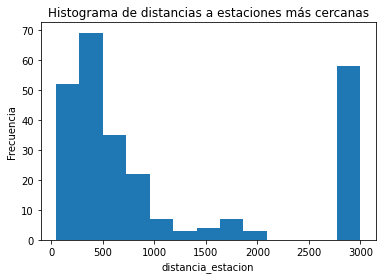

In [13]:
k = int(np.ceil(1+np.log2(3333)))
plt.hist(df["distancia_estacion"], bins = k)
plt.xlabel("distancia_estacion")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancias a estaciones más cercanas")

Text(0.5, 1.0, 'Histograma de superficie util (m2)')

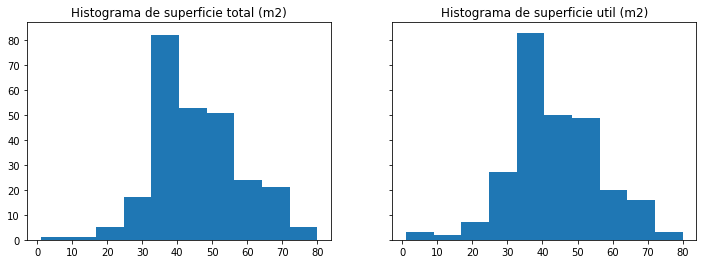

In [14]:
figure, axs = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
axs[0].hist(df["superficie_total"])
axs[0].set_title("Histograma de superficie total (m2)")
axs[1].hist(df["superficie_util"])
axs[1].set_title("Histograma de superficie util (m2)")

Text(0.5, 1.0, 'Histograma de totales en CLP')

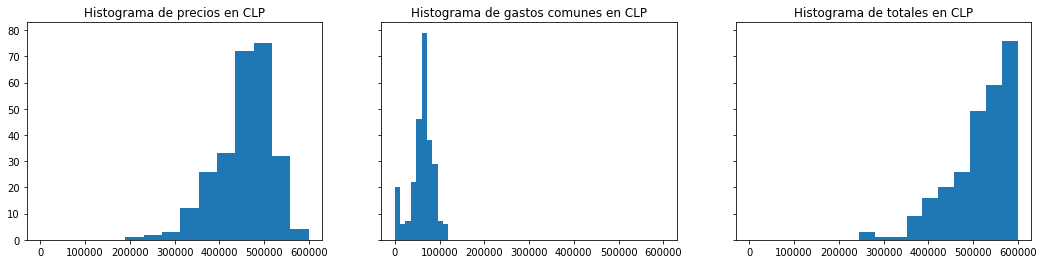

In [15]:
figure, axs = plt.subplots(1,3, figsize=(18,4), sharey=True, sharex=True)
axs[0].hist(df["precio"])
axs[0].set_title("Histograma de precios en CLP")
axs[1].hist(df["gastos_comunes"])
axs[1].set_title("Histograma de gastos comunes en CLP")
axs[2].hist(df["total"])
axs[2].set_title("Histograma de totales en CLP")

## Resumen de variables predictora categoricas

In [16]:
# Resumén estadístico de variables categoricas
df.describe(include = ['O'])

,comuna,estacion_cercana
count,260,260
unique,7,44
top,Ñuñoa,Sin estación cercana
freq,99,58


In [17]:
# Resumen por comuna
df.groupby(['comuna'])['comuna'].count().sort_values(ascending=False)

comuna
Ñuñoa          99
Macul          78
Providencia    48
Las Condes     20
La Florida      9
La Reina        3
Peñalolén       3
Name: comuna, dtype: int64

In [18]:
# Resumen por estción cercana, 10 primeras (de 45)
df.groupby(['estacion_cercana'])['estacion_cercana'].count().sort_values(ascending=False).head(10)

estacion_cercana
Sin estación cercana    58
Irarrázaval             18
Chile España            12
Estadio Nacional        12
Las Torres              11
Rodrigo de Araya        11
Villa Frei              11
Macul                   10
Monseñor Eyzaguirre      9
Quilín                   9
Name: estacion_cercana, dtype: int64

# Metodología de clasificación

Se utilizan métodos de *machine learning* para que un algoritmo computacional tenga la capacidad de aprender a través de los datos sin tener que programar reglas explicitas. Las aplicaciones son múltiples, entre algunos ejemplos se destacan la clasificación de *spam*, deteción de tumores, resumen de documentos, detección de fraudes, sistemas de recomendación, *chatbots* entre otros.

El enfoque general de *machine learning*, y el utilizado en este trabjo, comienza con un estudio del problema del cuál se desea aprender a clasificar o predecir (regresión), se realiza un estudio preliminar de los datos (AED), luego se selecciona y entrena un algoritmo a través de los datos, se evalua la solución y se iteran los parametros de ser necesario hasta obtener un modelo óptimo en su solución.

Las metodologías utilizadas en *machine learning* se puede clasificar en dos grandes grupos: de aprendizaje supervisado y no supervisado. El conjunto de datos del aprendizaje supervisado cuenta con ejemplos de soluciones deseadas, denominadas etiquetas, necesarios para que el método aprenda y pueda clasificar. Mientras que los métodos no supervisado no necesitan ejemplos para poder clasificar el conjunto de datos.

El presente trabajo experimentará con metodos de clasificación binaria de aprendizaje supervisado, dado que el conjunto de datos ya cuenta con etiquetas de preferencias (1: Si, 0: No) a clasificar, y tal como se señaló al incio, se desea contar con un algoritmo que pueda clasificar nuevos departamentos según las preferencias del investigador y su pareja, aportandole al método ejemplos de departamentos de sus gustos.

El métodos de clasificación seleccionado para este trabajo se trata de la máquina de vectores soporte (SVM, *Support Vector Machine*) dada su versatilidad, potencia y capacidad de trabajar con conjuntos de datos pequeños y medianos, y las medidas de rendimiento serán la validación cruzada, matriz de confusión, metricas de precisión y sensibilidad, y la curva ROC.

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn import svm

In [20]:
# Para usar los métodos SVM las variables categoricas "comuna" y "estacion_cercana" se transforman a variables dummys
df = pd.get_dummies(df)

In [21]:
# Separación de etiqueta Y y caracteristicas X
y = df.iloc[:,0]
X = df.iloc[:,1:]
# Subconjunto de entrenamiento y testing de 80 y 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((195, 61), (195,), (65, 61), (65,))

## Modelo SVM

Prueba del modelo SVM por defecto: C=1, kernel='rbf', degree=3

In [22]:
# Definición del modelo SVM
clf = svm.SVC()
# Entrenamiento del modelo
clf.fit(X_train, y_train)
# Precisión
clf.score(X_test, y_test)
# Predicción de X test
y_test_pred = clf.predict(X_test)

#### Cross Validation

In [23]:
# Clasificación SVC por defecto
accuracy = cross_val_score(clf, X, y, cv=5)
print(accuracy)
# Precisión promedio
print("Precisión promedio: ", accuracy.mean() * 100)

[0.84615385 0.84615385 0.84615385 0.84615385 0.84615385]
Precisión promedio:  84.61538461538461


Podemos observar que la precisión del modelo a través de *cross-validation* con k=10 es en promedio de 84.6%

In [24]:
# Obtención de predicciones por medio de validación cruzada
y_pred = cross_val_predict(clf, X, y, cv=10)
# Matriz de confusión
confusion_matrix(y, y_pred)

array([[220,   0],
       [ 40,   0]])

#### f1 score

In [25]:
f1_score(y_test, y_test_pred)

0.0

Si bien se observa la matriz de confusión puede clasificar perfectamente las preferencias 0, ha fallado el 100% de las preferencias 1, y tal como se conoce la naturaleza del problema, es más interesante poder clasificar correctamente la clase 1

#### auc score

In [26]:
roc_auc_score(y_test, y_test_pred)

0.5

## Prueba automatica de diferentes modelos SVM

In [27]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid'] :
    print('====> Kernel : ', kernel)
    for C in [0.1, 1, 1.5, 3] :
        print('==> C : ', C)
        clf_iter = svm.SVC(kernel=kernel, C=C)
        accuracy = cross_val_score(clf_iter, X, y, cv=5)
        print("Precisión promedio: ", accuracy.mean() * 100)
        clf_iter.fit(X_train, y_train)
        y_test_pred = clf_iter.predict(X_test)
        f1 = f1_score(y_test, y_test_pred, average='macro')
        confusion_matrix(y_test, y_test_pred)
        print('f1 : ', f1)
        aucscore = roc_auc_score(y_test, y_test_pred, average='macro')
        print('auc : ', aucscore)

====> Kernel :  linear
==> C :  0.1
Precisión promedio:  80.76923076923077


# Conclusión

Los métodos SVM entrenados no ha aportado buenos resultados en general para clasificar, el mejor modelo SVM es uno entrenado con kernel = lineal y C = 1 obtuvo el mejor desempeño en relación a los otros modelos entrenados, sin embargo, el rendimiento sigue siendo muy pobre para considerarse útil en su utilización. Es posible intentar mejorar el modelo aumentando la cantidad de datos de entrenamiento, o añadir más caracteristicas predictoras de departamentos o de mejor calidad explicativa. También es posible revisar más combinaciones de kernel, parametros C y otros parametros de SVM en el modelo para encontrar uno que aporte un rendimiento mucho mejor a la hora de clasificar, además de probar otros diferentes métodos de clasificación como bayes ingenuo o arboles de decisión.